# Quick Test that FastICA is sane and I'm using it right

In [1]:
from ml.nodes import *
from ml.unodes import *
from ml.traces import *
from ml.misc import *
import tensorflow as tf
import scipy.cluster.vq
import math
from sklearn.decomposition import FastICA, PCA

In [2]:
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
                                   MNIST:        0     N:-1 C:784 


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [4]:
x = ds.x
y_ = ds.y_

In [5]:
f = Flatten(ds)
batch = ds.train.next_batch(500)
vals = sess.run(f.out(), feed_dict={x: batch[0], y_: batch[1]})
    
print vals.shape

                                 Flatten:        0     N:-1 C:784 
(500, 784)


## A simple network:

1. An ICA rotation on the input data
1. Normalize the outputs because the ICA has no notion of scale
1. Maybe add a bias term for the next step...
1. Do a relu (on the positive and negative sides because the ICA has no sense of direction)
1. Standard linear/softmax/onehot

Ok, my class nodes are clearly not a good abstraction. I'll try something else soon.

In [6]:
def mkRun(n2, bias=True, crelu=True, ica=True):
    r = {}
    if ica:
        i = ICA(f, n2*n2)
        i.train(ds, sess)
        c = Norm(i)
        c.train(ds, sess)
        r['ica'] = i
    else:
        c = f
    if bias:
        c = Bias(c, .001)
    if crelu:
        c = Crelu(c)
    l = Linear(c, 10)
    r['l'] = l
    b = Bias(l, .001)

    s = SoftmaxCrossEntropyWithLogits(b, y_)
    sm = Softmax(b)
    r['sm'] = sm
    ce = Mean(s)

    acc = Accuracy(b, y_)

    rate2 = tf.placeholder(tf.float32)
    train_step = tf.train.GradientDescentOptimizer(rate2*5e2).minimize(ce.out())
    sess.run(tf.global_variables_initializer())
    return train_step, rate2, acc, r


In [7]:
def train(track, train_step, rate2, epochs=200, mb=10, verbose=True):
    sr = 1e-3
    er = 1e-5
    lr = sr
    decay = 1 / (1+math.log(sr/er) / epochs)
    nodes = track.nodes()
    for i in range(epochs):
        lr = lr * decay
        for j in range(mb):
            batch = ds.train.next_batch(50)
            vals = sess.run([train_step] + nodes, feed_dict={x: batch[0], y_: batch[1], rate2: lr})
            track.addBatch(vals[1:])
        r = sess.run(nodes, feed_dict={x: ds.validation.images(), y_: ds.validation.labels()})
        if verbose:
            print '%4d' % i,
            if (i+1) % 10 == 0:
                print '%8.04f %f' % (r[0]*100, lr)
        track.addEpoch(r)

## Basic stats for ICAs of various sizes

Mostly just to see how much info we lose as we discard minor dimensions...

In [8]:
setVerbose(False)

def doit(ica=True, **kw):
    if ica:
        m = 28
    else:
        m = 1
    r = None
    for i in range(1, m+1):
        try:
            train_step, rate2, acc, r = mkRun(i, ica=ica, **kw)
        except:
            continue
        track = Track([])
        train(track, train_step, rate2, verbose=False)
        print "%2d %3d: accuracy %8.04f %8.04f" % (i, 
                                                   i*i, 
                                                   acc.out().eval(feed_dict={ x: ds.validation.images(), y_: ds.validation.labels()}),
                                                   acc.out().eval(feed_dict={ x: ds.train.images(), y_: ds.train.labels()})
                                                   )
    return r
    

## With no ICA:

We should get near the score for MNIST for beginners.
Show us around 92%...

In [9]:
r = doit(bias=False, crelu=False, ica=False)

 1   1: accuracy   0.9160   0.9111


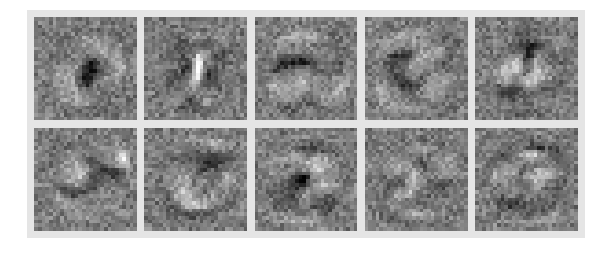

In [10]:
v = sess.run(r['l'].W)
show(v.T.reshape(1,2,5,28,28,1))

## Sanity check

The bias and crelu shouldn't add anything significant to the score...

In [11]:
doit(bias=True, crelu=True, ica=False)

 1   1: accuracy   0.9188   0.9119


{'l': <ml.nodes.Linear at 0x11b372650>,
 'sm': <ml.nodes.Softmax at 0x11b658910>}

## How much information is really in MNIST?

Adding the ICA layer (without a non-linear layer) should not improve the score (beyond just helping the optimizer a bit.)

Looks like we can compress our 984 inputs down to 144 nodes and still hit 90%+...

In [12]:
r = doit(bias=False, crelu=False)

 1   1: accuracy   0.3006   0.2983
 2   4: accuracy   0.5692   0.5675


/Users/michaelnaunton/anaconda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


 3   9: accuracy   0.7910   0.7819
 4  16: accuracy   0.8482   0.8440
 5  25: accuracy   0.8734   0.8698
 6  36: accuracy   0.8820   0.8819
 7  49: accuracy   0.8952   0.8867
 8  64: accuracy   0.9014   0.8935
 9  81: accuracy   0.9014   0.8953
10 100: accuracy   0.9018   0.8986
11 121: accuracy   0.9082   0.8997
12 144: accuracy   0.9094   0.9012
13 169: accuracy   0.9106   0.9033


/Users/michaelnaunton/anaconda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:58: RuntimeWarning: invalid value encountered in sqrt
  return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)


15 225: accuracy   0.9114   0.9051
16 256: accuracy   0.9130   0.9046
17 289: accuracy   0.9174   0.9060
18 324: accuracy   0.9144   0.9061
19 361: accuracy   0.9174   0.9079
20 400: accuracy   0.9162   0.9095
21 441: accuracy   0.9186   0.9098
22 484: accuracy   0.9178   0.9097
23 529: accuracy   0.9176   0.9106
24 576: accuracy   0.9196   0.9111
25 625: accuracy   0.9208   0.9107
26 676: accuracy   0.9208   0.9121
27 729: accuracy   0.9218   0.9150
28 784: accuracy   0.9222   0.9175


{'ica': <ml.unodes.ICA at 0x11f209e10>,
 'l': <ml.nodes.Linear at 0x11f322f10>,
 'sm': <ml.nodes.Softmax at 0x126dbfb10>}

## Ok, let's see if ICA works...

So we just spin the input data around unsupervised, add our Relu non-linearity, and hope we do a lot better:

In [13]:
r = doit(bias=False)

 1   1: accuracy   0.3064   0.3007
 2   4: accuracy   0.5998   0.5941
 3   9: accuracy   0.8078   0.7984
 4  16: accuracy   0.8688   0.8620
 5  25: accuracy   0.9008   0.8941
 6  36: accuracy   0.9176   0.9103
 7  49: accuracy   0.9280   0.9207
 8  64: accuracy   0.9432   0.9321
 9  81: accuracy   0.9432   0.9383
10 100: accuracy   0.9510   0.9445
11 121: accuracy   0.9560   0.9477
12 144: accuracy   0.9538   0.9525
13 169: accuracy   0.9614   0.9553
14 196: accuracy   0.9628   0.9565
16 256: accuracy   0.9646   0.9623
17 289: accuracy   0.9666   0.9630
18 324: accuracy   0.9672   0.9647
19 361: accuracy   0.9694   0.9652
20 400: accuracy   0.9682   0.9666
21 441: accuracy   0.9690   0.9652
22 484: accuracy   0.9690   0.9661
23 529: accuracy   0.9700   0.9648
24 576: accuracy   0.9684   0.9659
25 625: accuracy   0.9688   0.9660
26 676: accuracy   0.9656   0.9660
27 729: accuracy   0.9656   0.9644
28 784: accuracy   0.9610   0.9618


{'ica': <ml.unodes.ICA at 0x181e2ecd0>,
 'l': <ml.nodes.Linear at 0x182ffcd50>,
 'sm': <ml.nodes.Softmax at 0x1721efcd0>}

## Sanity Check

Letting the bias float might up the score a bit...

But we shouldn't expect much: the underlying ICA rotation/skew isn't centered well because so many inputs are black (i.e. 0.) Fixing the bias won't fix the sub-optimal rotation:

In [14]:
r = doit()

 1   1: accuracy   0.3014   0.3008
 2   4: accuracy   0.5966   0.5964
 3   9: accuracy   0.8144   0.8072
 4  16: accuracy   0.8668   0.8647
 5  25: accuracy   0.9074   0.9018
 6  36: accuracy   0.9200   0.9138
 7  49: accuracy   0.9294   0.9234
 8  64: accuracy   0.9436   0.9329
 9  81: accuracy   0.9420   0.9384
10 100: accuracy   0.9518   0.9455
11 121: accuracy   0.9560   0.9503
12 144: accuracy   0.9600   0.9550
13 169: accuracy   0.9612   0.9569
14 196: accuracy   0.9620   0.9572
15 225: accuracy   0.9654   0.9603
16 256: accuracy   0.9658   0.9638
17 289: accuracy   0.9686   0.9650
18 324: accuracy   0.9706   0.9661
19 361: accuracy   0.9686   0.9673
20 400: accuracy   0.9670   0.9665
21 441: accuracy   0.9686   0.9665
22 484: accuracy   0.9688   0.9659
23 529: accuracy   0.9690   0.9667
24 576: accuracy   0.9712   0.9654
25 625: accuracy   0.9684   0.9661
26 676: accuracy   0.9680   0.9663
27 729: accuracy   0.9646   0.9641
28 784: accuracy   0.9618   0.9622


{'ica': <ml.unodes.ICA at 0x1aeef2750>,
 'l': <ml.nodes.Linear at 0x1b3642e10>,
 'sm': <ml.nodes.Softmax at 0x1b5d59f50>}

28 784: accuracy   0.9744   0.9968


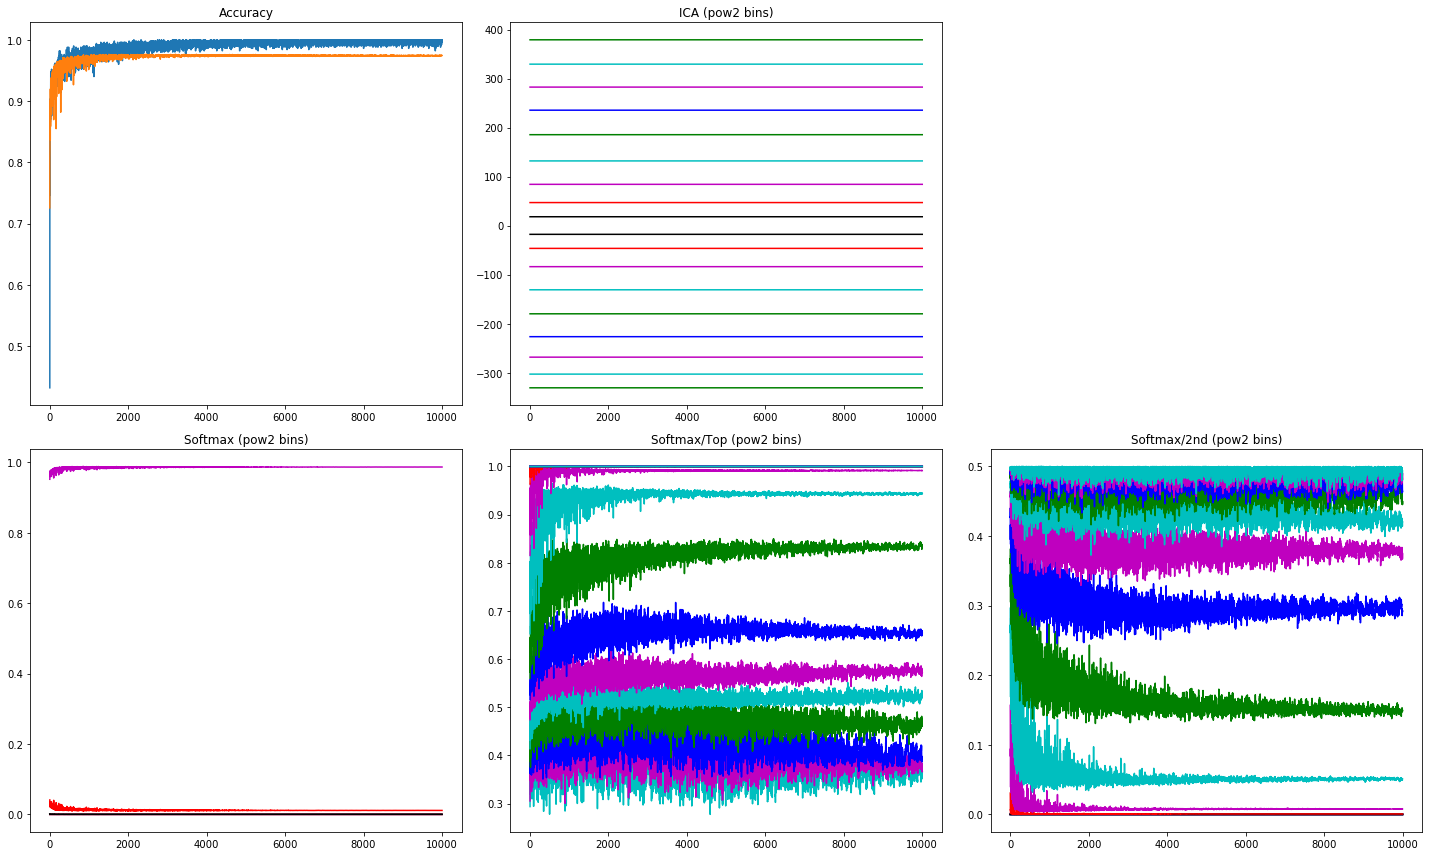

In [17]:
i = 28
train_step, rate2, acc, r = mkRun(i, bias=False, crelu=True)

sm = r['sm']

trackables = [ [ ScalarTrace(acc.out(), 'Accuracy',                 skip=0),
                 #ScalarTrace(ce.out(),  'Cross Entropy', yFn='log', skip=0), 
                 OutTrace(r['ica'].out(), 'ICA'),
               ],
              
               [ OutTrace(sm.out(), 'Softmax'),
                 TopTrace(sm.out(), 'Softmax/Top'),
                 TopTrace(sm.out(), 'Softmax/2nd', index=-2), ],
             ]

track = Track(trackables)
train(track, train_step, rate2, epochs=10000, mb=10, verbose=False)
print "%2d %3d: accuracy %8.04f %8.04f" % (i, 
                                           i*i, 
                                           acc.out().eval(feed_dict={ x: ds.validation.images(), y_: ds.validation.labels()}),
                                           acc.out().eval(feed_dict={ x: ds.train.images(), y_: ds.train.labels()})
                                           )
track.plotAll()